<a href="https://colab.research.google.com/github/VincentGaoHJ/Course-CS5242/blob/master/practice_3_multilayerPerceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practice 3: Multilayer Networks


In [189]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Pytorch has a wide variety of datasets that one can leverage. In this tutorial, we will
use one such dataset and build a multilayer neural network to fit the data. We will 
use PyTorch optimizers to perform the optimization process.**


Q1. Use the following snippet to get a dataloader from the already available Mnist dataset from 
PyTorch. Mnist dataset has 60,000 digit images with its corresponding labels.
This snippet will download the dataset if not downloaded already and transform each 
image before returning it. Dataloaders are iterable over a dataset. For further reading follow [pytorch dataloader](https://pytorch.org/docs/stable/data.html)

```python
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
traintloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
```

In [190]:
from torchvision import datasets, transforms

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) 
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Code for the test dataset and data loader
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

# Use the help command to see the dictionary elements, attributes and method of any object
help(trainloader)

Help on DataLoader in module torch.utils.data.dataloader object:

class DataLoader(typing.Generic)
 |  Data loader. Combines a dataset and a sampler, and provides an iterable over
 |  the given dataset.
 |  
 |  The :class:`~torch.utils.data.DataLoader` supports both map-style and
 |  iterable-style datasets with single- or multi-process loading, customizing
 |  loading order and optional automatic batching (collation) and memory pinning.
 |  
 |  See :py:mod:`torch.utils.data` documentation page for more details.
 |  
 |  Arguments:
 |      dataset (Dataset): dataset from which to load the data.
 |      batch_size (int, optional): how many samples per batch to load
 |          (default: ``1``).
 |      shuffle (bool, optional): set to ``True`` to have the data reshuffled
 |          at every epoch (default: ``False``).
 |      sampler (Sampler or Iterable, optional): defines the strategy to draw
 |          samples from the dataset. Can be any ``Iterable`` with ``__len__``
 |         

Q2. Wrap the dataloader with python “iter” class which will give you an iterable object from which you can get new images and labels using .next(). After applying iter, iterate through a few samples, check the shape, the datatype of the image, label tuple that you are getting. Plot some of the images. Also, print the flattened shape of each image. (hint: use .flatten())


In [191]:
print('Dataset: ', trainloader.dataset)
print('samples per batch: ', trainloader.batch_size)

Dataset:  Dataset MNIST
    Number of datapoints: 60000
    Root location: /root/.pytorch/MNIST_data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
samples per batch:  64


In [192]:
# Here we are doing some initial analysis of what .next of dataloader returns
train_iter = iter(trainloader)
batches, labels = train_iter.next()

# check the shape
print('Tensor shape: ', batches.shape)
# the datatype of the image
print('Datatype of image: ', batches.type)
# label tuple that you are getting
print('Label tuple: ', labels)
# Also, print the flattened shape of each image. (hint: use .flatten())
print('Flattened shape of each image: ', batches[0].flatten().shape)

Tensor shape:  torch.Size([64, 1, 28, 28])
Datatype of image:  <built-in method type of Tensor object at 0x7efd1b512288>
Label tuple:  tensor([9, 5, 0, 7, 4, 9, 0, 8, 1, 8, 8, 2, 9, 0, 6, 1, 4, 7, 2, 2, 1, 8, 7, 6,
        9, 4, 1, 2, 8, 3, 5, 0, 9, 1, 4, 0, 4, 2, 0, 0, 3, 5, 9, 4, 0, 8, 0, 4,
        8, 4, 4, 6, 4, 4, 7, 1, 0, 4, 0, 7, 9, 3, 7, 0])
Flattened shape of each image:  torch.Size([784])


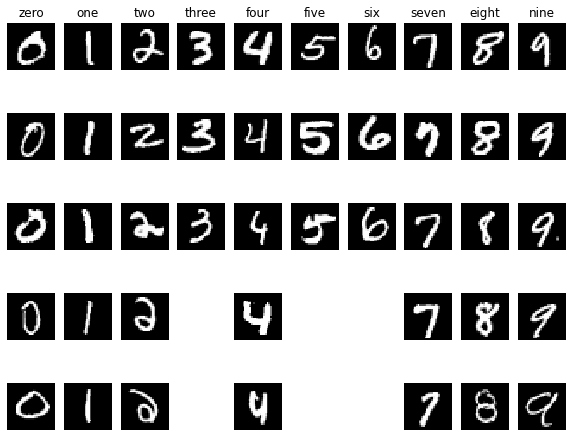

In [193]:
np.random.seed(0)     # We need to set the seed to help in reproducibility of data

length_of_dict_class = 10 # This indicates we have 10 labels corresponding to Mnist dataset
dict_class = {0:"zero", 1:"one", 2: "two", 3: "three", 4:"four", 5:"five", 6:"six", 7:"seven", 8:"eight", 9:"nine"}

# Since we notice the dimension of image is 1 * 28 * 28, this means image is gray scale, 
# it has only one channel, we should squeeze the extra dimension


def visualize_images(examples_per_class):
    
    for cls in range(length_of_dict_class):
        idxs = np.where((labels == cls))[0] # Find index of the specific class
        # If in this batch we do not get the required number of samples we want to show, skip
        if len(idxs) >= examples_per_class:
            idxs = np.random.choice(idxs, examples_per_class, replace=False) 
        
        # Plot here
        for enu_idx, img_idx in enumerate(idxs):
            plt_index = enu_idx * length_of_dict_class + cls + 1
            plt.subplot(examples_per_class, length_of_dict_class, plt_index)
            plt.imshow(torch.squeeze(batches[img_idx]))
            plt.axis('off')
            if enu_idx == 0:
                plt.title(dict_class[cls])
    
visualize_images(5)


Q3. Build a multilayer neural network with 3 fully connected layers of shape (784, 128), (128, 64) and then (64, 10). Use ReLu activation in between each layer, and at the end of the output layer. 
The class should have a forward function that you will manually create. The forward will take image batch as an input (image_batch * flattened_image_784_size) and return (image_batch x 10) size vectors.

**Hint**: Use torch.nn.Linear for linear layers. Follow this pytorch module to understand how to inherit the [pytorch module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module) class.


In [194]:
# Declare device which you will be working with
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [195]:
class Model(nn.Module):
    """
    Multilayer neural network with 3 fully connected layers of shape 
    (784, 128) -> (128, 64) -> (64, 10)
    """

    # Use ReLu activation in between each layer, and at the end of the output layer. 
    # The class should have a forward function that you will manually create. 
    # The forward will take image batch as an input (image_batch * flattened_image_784_size) and return (image_batch x 10) size vectors.
    def __init__(self):
        # Creates an instance of the base nn.Module class
        super(Model, self).__init__() # Inheritance of the base class nn.Module
        # Fully connected layers
        self.fc1 = nn.Linear(784, 128) # 28 x 28 input pixels connecting to the first hidden layer (128 node)
        self.fc2 = nn.Linear(128, 64) # 128 to 64 hidden layer
        self.fc3 = nn.Linear(64, 10) # last hidden layer to the output layer (with 10 nodes).

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# network = Model().to(device)
# print(network)

Q4. Create a cross-entropy loss. You can create it yourself (just like the last tutorial) or create it by using torch.nn.CrossEntropyLoss (pytorch cross-entropy loss uses logits, not softmax probabilities, so we had not applied softmax at the last layer). Initialize an SGD optimizer from torch.optim. 

**PyTorch Loss-Input Confusion (Cheatsheet)**

*   torch.nn.functional.binary_cross_entropy takes logistic sigmoid values as inputs
*   torch.nn.functional.binary_cross_entropy_with_logits takes logits as inputs
*   torch.nn.functional.cross_entropy takes logits as inputs (performs log_softmax internally)
*   torch.nn.functional.nll_loss is like cross_entropy but takes log-probabilities (log-softmax) values as inputs


In [196]:
# used 0.1 learning rate
learning_rate = 0.1
momentum = 0
# create a stochastic gradient descent optimizer
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum) 
# create a loss function
criterion = nn.CrossEntropyLoss()


Q5. (1 pass of the data) Write a training loop which will 
1.	Get data batches from dataloader, feed it into the network and get outputs.
2.	Get loss using outputs and ground truth labels.
3.	Call backward on the loss (remember to clear grads before calling gradients)
4.	Call optimizer.step to perform SGD update.
5.	Print the accuracy, loss and amount of data used till now.


**Note**: We have used only training split in this week tutorial for sake of simplicity of the tutorial. 


In [197]:
def cal_acc(outputs, labels):
    # probs: probability that each image is labeled as 1
    # target: ground truth label
    correct = 0
    total = 0
    with torch.no_grad():
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return 100 * correct / total

def train_one_pass(p_network, criterion, p_optim, trainloader, epoch=1, log_interval=100):
    p_network.train()
    acc_one_pass, loss_one_pass = [], []
    for idx, (images, labels) in enumerate(trainloader):
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device) # resize data from (batch_size, 1, 28, 28) to (batch_size, 28*28)
        labels = labels.to(device)
        
        # Forward pass
        model_out = p_network(images)
        loss = criterion(model_out, labels) # Get loss using outputs and ground truth labels.
        
        # Backprpagation and optimization
        p_optim.zero_grad() # remember to clear grads before calling gradients
        loss.backward() # Call backward on the loss ()
        p_optim.step() # Call optimizer.step to perform SGD update.
        
        acc = cal_acc(model_out, labels) # Print the accuracy, loss and amount of data used till now.

        # Print Information
        if (idx + 1) % log_interval == 0:
            print('Iter: [{}/{} ({:.2f}%)] \t Train Loss: {:.4f} \t Train Accuracy: {:.2f}%'.format(
                (idx+1) * len(images), len(trainset), 
                100.*(idx+1) * len(images)/len(trainset), loss, acc))
        acc_one_pass.append(acc)
        loss_one_pass.append(loss)
    
    avg_acc = sum(acc_one_pass) / len(acc_one_pass)
    avg_loss = sum(loss_one_pass) / len(loss_one_pass)
    print('Train on Epoch: {} \t Loss: {:.4f} \t Accuracy: {:.2f}%'.format(
        epoch, avg_loss, avg_acc).center(76, '='))


def test_one_pass(p_network, testloader, epoch=1):
    p_network.eval()
    loss_lst, acc_lst = [], []
    with torch.no_grad():
        for images, labels in testloader:
            images = images.reshape(-1, 28*28).to(device) # resize data from (batch_size, 1, 28, 28) to (batch_size, 28*28)
            labels = labels.to(device)
            model_out = p_network(images)
            loss = criterion(model_out, labels)
            acc = cal_acc(model_out, labels)
            loss_lst.append(loss)
            acc_lst.append(acc)
    loss = sum(loss_lst) / len(loss_lst)
    acc = sum(acc_lst) / len(acc_lst)
    print('Test on Epoch: {} \t Loss: {:.4f} \t Accuracy: {:.2f}%'.format(
        epoch, loss, acc).center(76, '='))

network = Model().to(device)

# Loss and optimizer
optimizer = torch.optim.SGD(network.parameters(), lr=0.01, momentum=momentum) 

# Train the model
train_one_pass(network, criterion, optimizer, trainloader)

# Test the model
test_one_pass(network, testloader)

Iter: [6400/60000 (10.67%)] 	 Train Loss: 2.1583 	 Train Accuracy: 40.62%
Iter: [12800/60000 (21.33%)] 	 Train Loss: 1.6513 	 Train Accuracy: 60.94%
Iter: [19200/60000 (32.00%)] 	 Train Loss: 1.1374 	 Train Accuracy: 71.88%
Iter: [25600/60000 (42.67%)] 	 Train Loss: 0.9190 	 Train Accuracy: 75.00%
Iter: [32000/60000 (53.33%)] 	 Train Loss: 0.6841 	 Train Accuracy: 82.81%
Iter: [38400/60000 (64.00%)] 	 Train Loss: 0.6448 	 Train Accuracy: 87.50%
Iter: [44800/60000 (74.67%)] 	 Train Loss: 0.5599 	 Train Accuracy: 81.25%
Iter: [51200/60000 (85.33%)] 	 Train Loss: 0.4814 	 Train Accuracy: 85.94%
Iter: [57600/60000 (96.00%)] 	 Train Loss: 0.4426 	 Train Accuracy: 81.25%
============Train on Epoch: 1 	 Loss: 1.0552 	 Accuracy: 72.00%=============
=============Test on Epoch: 1 	 Loss: 0.4545 	 Accuracy: 86.37%=============



Q6. (Multiple Passes of Data) Write a loop to perform the training pass for 50 training iterations (50 epochs, this is outer for loop of data loader). Print and save accuracy and loss after each epoch.


In [198]:
def multiple_pass(model, criterion, optimizer, train_loader, testloader, num_epochs=10, log_interval=300):
    # Train the model
    total_step = len(train_loader)
    for epoch in range(1, num_epochs + 1):
        train_one_pass(model, criterion, optimizer, train_loader, 
                       epoch=epoch, log_interval=log_interval)
        test_one_pass(model, testloader, 
                      epoch=epoch)

network = Model().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=0.01, momentum=momentum) 

# Train and Test
multiple_pass(network, criterion, optimizer, trainloader, testloader,
              num_epochs=10)

Iter: [19200/60000 (32.00%)] 	 Train Loss: 1.1691 	 Train Accuracy: 78.12%
Iter: [38400/60000 (64.00%)] 	 Train Loss: 0.7226 	 Train Accuracy: 79.69%
Iter: [57600/60000 (96.00%)] 	 Train Loss: 0.3608 	 Train Accuracy: 93.75%
============Train on Epoch: 1 	 Loss: 1.0104 	 Accuracy: 71.39%=============
=============Test on Epoch: 1 	 Loss: 0.4279 	 Accuracy: 88.19%=============
Iter: [19200/60000 (32.00%)] 	 Train Loss: 0.2429 	 Train Accuracy: 95.31%
Iter: [38400/60000 (64.00%)] 	 Train Loss: 0.2030 	 Train Accuracy: 95.31%
Iter: [57600/60000 (96.00%)] 	 Train Loss: 0.4817 	 Train Accuracy: 84.38%
============Train on Epoch: 2 	 Loss: 0.3835 	 Accuracy: 89.08%=============
=============Test on Epoch: 2 	 Loss: 0.3331 	 Accuracy: 90.26%=============
Iter: [19200/60000 (32.00%)] 	 Train Loss: 0.2352 	 Train Accuracy: 93.75%
Iter: [38400/60000 (64.00%)] 	 Train Loss: 0.2316 	 Train Accuracy: 90.62%
Iter: [57600/60000 (96.00%)] 	 Train Loss: 0.1975 	 Train Accuracy: 95.31%
============Train


Q7. Play around with the momentum of the SGD optimizer and then replace the SGD optimizer with Adam and RMSProp and analyze the loss trajectory (save the value of loss in an array after each update) of 50 training iterations for each of these types of optimizers. 


In [199]:
network = Model().to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
adam_optim = torch.optim.Adam(network.parameters(), lr=0.01) 

# Train and Test
multiple_pass(network, criterion, adam_optim, trainloader, testloader,
              num_epochs=10)

Iter: [19200/60000 (32.00%)] 	 Train Loss: 0.1747 	 Train Accuracy: 92.19%
Iter: [38400/60000 (64.00%)] 	 Train Loss: 0.2565 	 Train Accuracy: 92.19%
Iter: [57600/60000 (96.00%)] 	 Train Loss: 0.2517 	 Train Accuracy: 92.19%
============Train on Epoch: 1 	 Loss: 0.3899 	 Accuracy: 88.04%=============
=============Test on Epoch: 1 	 Loss: 0.2676 	 Accuracy: 92.34%=============
Iter: [19200/60000 (32.00%)] 	 Train Loss: 0.1213 	 Train Accuracy: 95.31%
Iter: [38400/60000 (64.00%)] 	 Train Loss: 0.1626 	 Train Accuracy: 93.75%
Iter: [57600/60000 (96.00%)] 	 Train Loss: 0.2421 	 Train Accuracy: 92.19%
============Train on Epoch: 2 	 Loss: 0.2500 	 Accuracy: 92.62%=============
=============Test on Epoch: 2 	 Loss: 0.2099 	 Accuracy: 93.80%=============
Iter: [19200/60000 (32.00%)] 	 Train Loss: 0.3708 	 Train Accuracy: 92.19%
Iter: [38400/60000 (64.00%)] 	 Train Loss: 0.4265 	 Train Accuracy: 87.50%
Iter: [57600/60000 (96.00%)] 	 Train Loss: 0.0350 	 Train Accuracy: 100.00%
============Trai


Q8. Play around with the initialization function like uniform and gaussian learnt in the lecture slides.


In [200]:
def init_weights_uniform(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.uniform_(0.0, 1.0) # uniform distribution(bias=0)
        m.bias.data.fill_(0)

# Initialize Weight
network_initialized = Model().to(device)
network_initialized.apply(init_weights_uniform)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
adam_optim = torch.optim.Adam(network_initialized.parameters(), lr=0.01) 

# Train and Test
print("Now running the uniformed initialized model with Adam Optimizer")
multiple_pass(network_initialized, criterion, adam_optim, trainloader, testloader,
              num_epochs=10)

Now running the uniformed initialized model with Adam Optimizer
Iter: [19200/60000 (32.00%)] 	 Train Loss: 2.2964 	 Train Accuracy: 7.81%
Iter: [38400/60000 (64.00%)] 	 Train Loss: 2.2987 	 Train Accuracy: 12.50%
Iter: [57600/60000 (96.00%)] 	 Train Loss: 2.3042 	 Train Accuracy: 7.81%
============Train on Epoch: 1 	 Loss: 2.3021 	 Accuracy: 10.97%=============
=============Test on Epoch: 1 	 Loss: 2.3014 	 Accuracy: 11.36%=============
Iter: [19200/60000 (32.00%)] 	 Train Loss: 2.3021 	 Train Accuracy: 10.94%
Iter: [38400/60000 (64.00%)] 	 Train Loss: 2.2904 	 Train Accuracy: 17.19%
Iter: [57600/60000 (96.00%)] 	 Train Loss: 2.2963 	 Train Accuracy: 18.75%
============Train on Epoch: 2 	 Loss: 2.3021 	 Accuracy: 10.92%=============
=============Test on Epoch: 2 	 Loss: 2.3020 	 Accuracy: 11.45%=============
Iter: [19200/60000 (32.00%)] 	 Train Loss: 2.3152 	 Train Accuracy: 9.38%
Iter: [38400/60000 (64.00%)] 	 Train Loss: 2.3031 	 Train Accuracy: 10.94%
Iter: [57600/60000 (96.00%)] 	 

In [202]:
def weights_init_normal(m):
        classname = m.__class__.__name__
        if classname.find('Linear') != -1:
            y = m.in_features
            m.weight.data.normal_(0.0,1/np.sqrt(y))
            m.bias.data.fill_(0)

# Initialize Weight
network_initialized = Model().to(device)
network_initialized.apply(weights_init_normal)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
adam_optim = torch.optim.Adam(network_initialized.parameters(), lr=0.01) 

# Train and Test
print("Now running the normal distribution initialized model with Adam Optimizer")
multiple_pass(network_initialized, criterion, adam_optim, trainloader, testloader,
              num_epochs=10)

Now running the normal distribution initialized model with Adam Optimizer
Iter: [19200/60000 (32.00%)] 	 Train Loss: 0.6961 	 Train Accuracy: 89.06%
Iter: [38400/60000 (64.00%)] 	 Train Loss: 0.4315 	 Train Accuracy: 82.81%
Iter: [57600/60000 (96.00%)] 	 Train Loss: 0.2836 	 Train Accuracy: 90.62%
============Train on Epoch: 1 	 Loss: 0.4067 	 Accuracy: 87.76%=============
=============Test on Epoch: 1 	 Loss: 0.2372 	 Accuracy: 92.87%=============
Iter: [19200/60000 (32.00%)] 	 Train Loss: 0.2362 	 Train Accuracy: 93.75%
Iter: [38400/60000 (64.00%)] 	 Train Loss: 0.1793 	 Train Accuracy: 95.31%
Iter: [57600/60000 (96.00%)] 	 Train Loss: 0.2599 	 Train Accuracy: 92.19%
============Train on Epoch: 2 	 Loss: 0.2424 	 Accuracy: 92.77%=============
=============Test on Epoch: 2 	 Loss: 0.2320 	 Accuracy: 93.07%=============
Iter: [19200/60000 (32.00%)] 	 Train Loss: 0.1367 	 Train Accuracy: 96.88%
Iter: [38400/60000 (64.00%)] 	 Train Loss: 0.1626 	 Train Accuracy: 93.75%
Iter: [57600/60000


Q9. Add batch normalization to each of the layers before ReLu activation function. Check how your results or iterations vary.

In [203]:
class Model_Normalization(nn.Module):
    def __init__(self):
        super(Model_Normalization, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.bn1 = nn.BatchNorm1d(num_features=128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(num_features=64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x


# Initialize Weight
network_initialized = Model_Normalization().to(device)
network_initialized.apply(weights_init_normal)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
adam_optim = torch.optim.Adam(network_initialized.parameters(), lr=0.01) 

# Train and Test
print("Now running the normal distribution initialized model with Adam Optimizer")
multiple_pass(network_initialized, criterion, adam_optim, trainloader, testloader,
              num_epochs=10)

Now running the normal distribution initialized model with Adam Optimizer
Iter: [19200/60000 (32.00%)] 	 Train Loss: 0.0947 	 Train Accuracy: 98.44%
Iter: [38400/60000 (64.00%)] 	 Train Loss: 0.2248 	 Train Accuracy: 98.44%
Iter: [57600/60000 (96.00%)] 	 Train Loss: 0.2623 	 Train Accuracy: 93.75%
============Train on Epoch: 1 	 Loss: 0.2025 	 Accuracy: 93.72%=============
=============Test on Epoch: 1 	 Loss: 0.1104 	 Accuracy: 96.37%=============
Iter: [19200/60000 (32.00%)] 	 Train Loss: 0.0677 	 Train Accuracy: 96.88%
Iter: [38400/60000 (64.00%)] 	 Train Loss: 0.1773 	 Train Accuracy: 96.88%
Iter: [57600/60000 (96.00%)] 	 Train Loss: 0.1185 	 Train Accuracy: 95.31%
============Train on Epoch: 2 	 Loss: 0.1032 	 Accuracy: 96.80%=============
=============Test on Epoch: 2 	 Loss: 0.0914 	 Accuracy: 97.18%=============
Iter: [19200/60000 (32.00%)] 	 Train Loss: 0.0449 	 Train Accuracy: 98.44%
Iter: [38400/60000 (64.00%)] 	 Train Loss: 0.0558 	 Train Accuracy: 98.44%
Iter: [57600/60000